In [136]:
import pandas as pd
import numpy as np
from pathlib import Path

import torch
from torch.utils.data import DataLoader, Dataset
from torch import nn

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import nltk
from tqdm import tqdm
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from string import punctuation
from stop_words import get_stop_words
from nltk.stem import WordNetLemmatizer

import matplotlib.pyplot as plt

nltk.download("punkt")

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Alexidis\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


'cpu'

In [137]:
def preprocess_text(txt):
    # Почему-то при параллельном запуске переменные из вне не видны

    sw = set(get_stop_words("en"))
    puncts= set(punctuation)
    lemmatizer = WordNetLemmatizer()

    txt = str(txt)
    txt = "".join(c for c in txt if c not in puncts)
    txt = txt.lower()
    txt = [lemmatizer.lemmatize(word) for word in txt.split() if word not in sw]
    return " ".join(txt)

In [138]:
def text_to_sequence(text, maxlen, vocabulary):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])
    padding = [0] * (maxlen-len(result))
    return result[-maxlen:] + padding

In [139]:
class DataWrapper(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).long()
        self.target = torch.from_numpy(target).long()
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]

        if self.transform:
            x = self.transform(x)

        return x, y

    def __len__(self):
        return len(self.data)

In [140]:
class GRUFixedLen(nn.Module) :
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=128, use_last=True):
        super().__init__()
        self.use_last = use_last
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.gru = nn.GRU(embedding_dim, int(hidden_dim /2), num_layers=2, batch_first=True
         ,bidirectional=True
        )
        self.linear = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.embeddings(x)
        x = self.dropout(x)
        gru_out, ht = self.gru(x)

        if self.use_last:
            last_tensor = gru_out[:,-1,:]
        else:
            # use mean
            last_tensor = torch.mean(gru_out[:,:], dim=1)

        out = self.linear(last_tensor)
        return torch.sigmoid(out)

In [141]:
TRAIN_FILEPATH = Path('./inputs/Twitter Sentiment Analysis/train.csv')

df = pd.read_csv(TRAIN_FILEPATH)

df_train, df_val = train_test_split(df, random_state=42, test_size=0.3)
df_train.shape, df_val.shape

((22373, 3), (9589, 3))

In [142]:
df_train.head()

,id,label,tweet
9635,9636,0,summer timeð #summeriscoming #swimming #pic...
2447,2448,0,"dese niggas will show dese otha bitches on fb,..."
16134,16135,0,"""when you are you boost your immune system a..."
18393,18394,0,reading my manuscript and not wanting to stop....
4420,4421,0,baby says he hates me today


In [143]:
%%time
tqdm.pandas()

df_train['tweet'] = df_train['tweet'].progress_apply(preprocess_text)
df_val['tweet'] = df_val['tweet'].progress_apply(preprocess_text)

100%|██████████| 9589/9589 [00:00<00:00, 20749.55it/s]

Wall time: 1.62 s


In [153]:
train_corpus = " ".join(df_train["tweet"])
train_corpus = train_corpus.lower()
tokens = word_tokenize(train_corpus)

In [154]:
max_words = 7000
max_len = 8
num_classes = 1
embedding_dim = 128
out_channel = 20

# Training
epochs = 5
batch_size = 512
print_batch_n = 100

In [155]:
tokens_filtered = [word for word in tokens if word.isalnum()]

dist = FreqDist(tokens_filtered)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}

In [156]:
x_train = np.asarray([text_to_sequence(text, max_len, vocabulary) for text in df_train["tweet"]], dtype=np.int32)
x_val = np.asarray([text_to_sequence(text, max_len, vocabulary) for text in df_val["tweet"]], dtype=np.int32)

In [157]:
train_dataset = DataWrapper(x_train, df_train['label'].values)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = DataWrapper(x_val, df_val['label'].values)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [158]:
gru_init = GRUFixedLen(max_words, embedding_dim, out_channel, use_last=False)
optimizer = torch.optim.Adam(gru_init.parameters(), lr=0.0015)
criterion = nn.BCELoss()

In [159]:
print(gru_init)
print("Parameters:", sum([param.nelement() for param in gru_init.parameters()]))

GRUFixedLen(
  (embeddings): Embedding(7000, 128, padding_idx=0)
  (gru): GRU(128, 10, num_layers=2, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=20, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
Parameters: 906341


In [160]:
gru_init = gru_init.to(device)
gru_init.train()
th = 0.5

train_loss_history = []
test_loss_history = []

for epoch in range(epochs):
    gru_init.train()
    running_loss, score = 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        # обнуляем градиент
        optimizer.zero_grad()
        outputs = gru_init(inputs)

        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        # подсчет ошибки на обучении
        loss = loss.item()
        # подсчет метрики на обучении
        pred_labels = torch.squeeze((outputs > th).int())
        score = f1_score(labels, pred_labels, average='weighted')

    # выводим статистику о процессе обучения
    gru_init.eval()

    print(f'Epoch [{epoch + 1}/{epochs}]. '
            f'Step [{i + 1}/{len(train_loader)}]. '
            f'Loss: {loss:.3f}. '
            f'F_score: {score :.3f}', end='. ')
    running_loss, score = 0.0, 0.0
    train_loss_history.append(loss)

    # выводим статистику на тестовых данных
    test_score, test_loss = 0.0, 0.0
    for j, data in enumerate(val_loader):
        test_labels = data[1].to(device)
        test_outputs = gru_init(data[0].to(device))

        # подсчет ошибки на тесте
        test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))
        # подсчет метрики на тесте
        pred_test_labels = torch.squeeze((test_outputs > th).int())
        test_score = f1_score(test_labels, pred_test_labels, average='weighted')

    test_loss_history.append(test_loss.item())
    print(f'Test loss: {test_loss:.3f}. Test F_score: {test_score:.3f}')

print('Training is finished!')

Epoch [1/5]. Step [44/44]. Loss: 0.240. F_score: 0.917. Test loss: 0.274. Test F_score: 0.885
Epoch [2/5]. Step [44/44]. Loss: 0.262. F_score: 0.878. Test loss: 0.257. Test F_score: 0.892
Epoch [3/5]. Step [44/44]. Loss: 0.164. F_score: 0.928. Test loss: 0.168. Test F_score: 0.930
Epoch [4/5]. Step [44/44]. Loss: 0.174. F_score: 0.921. Test loss: 0.132. Test F_score: 0.950
Epoch [5/5]. Step [44/44]. Loss: 0.172. F_score: 0.929. Test loss: 0.148. Test F_score: 0.940
Training is finished!


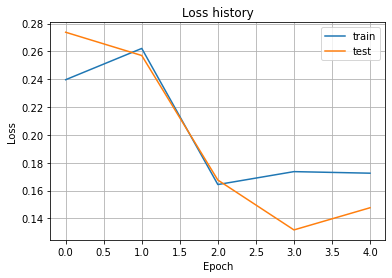

In [161]:
plt.title('Loss history')
plt.grid(True)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(train_loss_history, label='train')
plt.plot(test_loss_history, label='test')
plt.legend();